### A. Goldman, N. Puchkin, V. Shcherbakova, and U. Vinogradova

### Numerical experiments on artificial data sets, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [29]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from sklearn.preprocessing import MinMaxScaler

# Import the algorithms for comparison
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.contrastive_change_point import compute_test_stat_nn
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum

%matplotlib inline

np.random.seed(1)

### CENSREC data set

In [30]:
# Read the data
input_data = read('data/CENSREC/MAH_clean.wav')
audio_clean = input_data[1]

input_data = read('data/CENSREC/MAH_N1_SNR15.wav')
audio_snr15 = input_data[1]

input_data = read('data/CENSREC/MAH_N1_SNR20.wav')
audio_snr20 = input_data[1]

In [31]:
# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))

audio_clean_scaled = scaler.fit_transform(audio_clean.reshape(-1, 1))
audio_clean_scaled = audio_clean_scaled.reshape(-1)

audio_snr15_scaled = scaler.fit_transform(audio_snr15.reshape(-1, 1))
audio_snr15_scaled = audio_snr15_scaled.reshape(-1)

audio_snr20_scaled = scaler.fit_transform(audio_snr20.reshape(-1, 1))
audio_snr20_scaled = audio_snr20_scaled.reshape(-1)


# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_clean_scaled.shape[0] // bandwidth

data_clean = np.empty(0)
data_snr15 = np.empty(0)
data_snr20 = np.empty(0)

for t in range(N):
        
    data_clean = np.append(data_clean, np.mean(audio_clean_scaled[bandwidth * t : bandwidth * (t + 1)]))
    data_snr15 = np.append(data_snr15, np.mean(audio_snr15_scaled[bandwidth * t : bandwidth * (t + 1)]))
    data_snr20 = np.append(data_snr20, np.mean(audio_snr20_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)

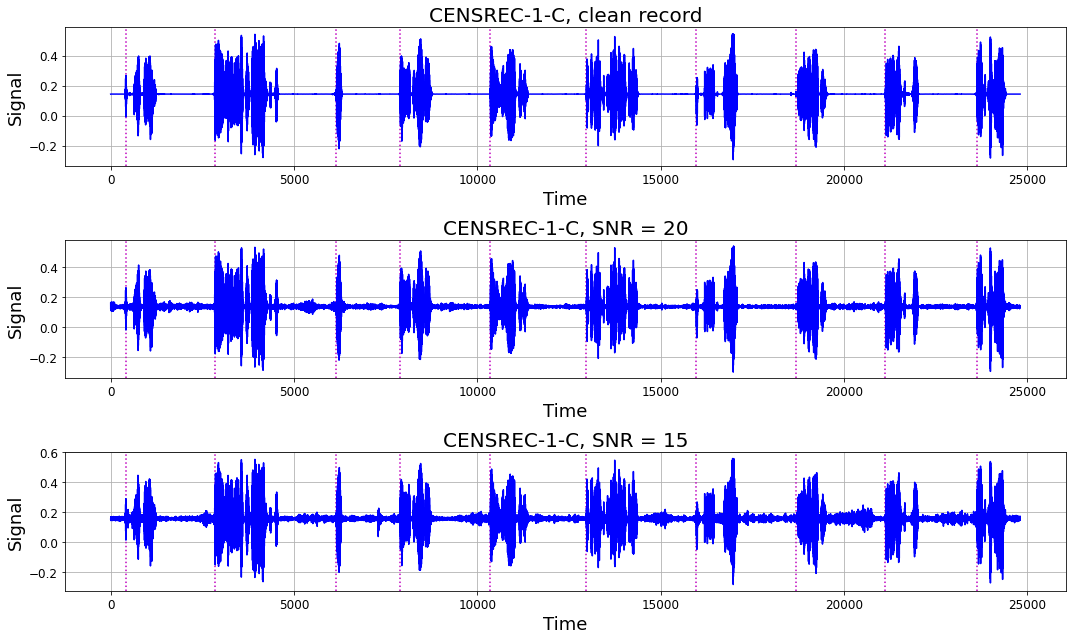

In [32]:
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data_clean.shape[0]), data_clean, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, clean record', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)
for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data_snr20.shape[0]), data_snr20, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR = 20', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)
for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(data_snr15.shape[0]), data_snr15, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, SNR = 15', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.tight_layout()
plt.savefig('images/CENSREC.png')

### CENSREC, clean record

In [33]:
# Read the data
input_data = read('data/CENSREC/MAH_clean.wav')
audio = input_data[1]

# Data preprocessing

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


In [34]:
z_lin = 12.967695368901623
p = 3

S_lin_all = []

for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_lin = np.empty(0)

    # Initialization 
    st_lin = 0
    new_st_lin = 0

    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(ds[st_lin + 1:], p, design='poly',\
                                                         delta_max=50, threshold=z_lin)

        S_lin = np.append(S_lin, new_S_lin)

        if new_st_lin >= 0:
            st_lin += new_st_lin

    S_lin_all += [S_lin]

In [35]:
z_nn = 0.00030194944507959794

S_nn_all = []

for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_nn = np.empty(0)

    # Initialization 
    st_nn = 0
    new_st_nn = 0

    while new_st_nn >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_nn, new_st_nn = compute_test_stat_nn(ds[st_nn + 1:], n_epochs=20, delta_max=50, threshold=z_nn)

        S_nn = np.append(S_nn, new_S_nn)

        if new_st_nn >= 0:
            st_nn += new_st_nn

    S_nn_all += [S_nn]

In [36]:
z_ftal = 0.01
b = 0.5
p = 3

S_ftal_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z_ftal)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            
    S_ftal_all += [S_ftal]
    
    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z_ftal)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            
    S_ftal_all += [S_ftal]

In [37]:
z_kliep = 0.3787829327687041
sigma = 0.025

S_kliep_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=0.02, threshold=z_kliep)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            
    S_kliep_all += [S_kliep]

    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_kliep)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            
    S_kliep_all += [S_kliep]

In [38]:
z_mmd = 0.004677456667637606
sigma = 0.1

S_mmd_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_mmd)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            
    S_mmd_all += [S_mmd]
    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_mmd)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            
    S_mmd_all += [S_mmd]

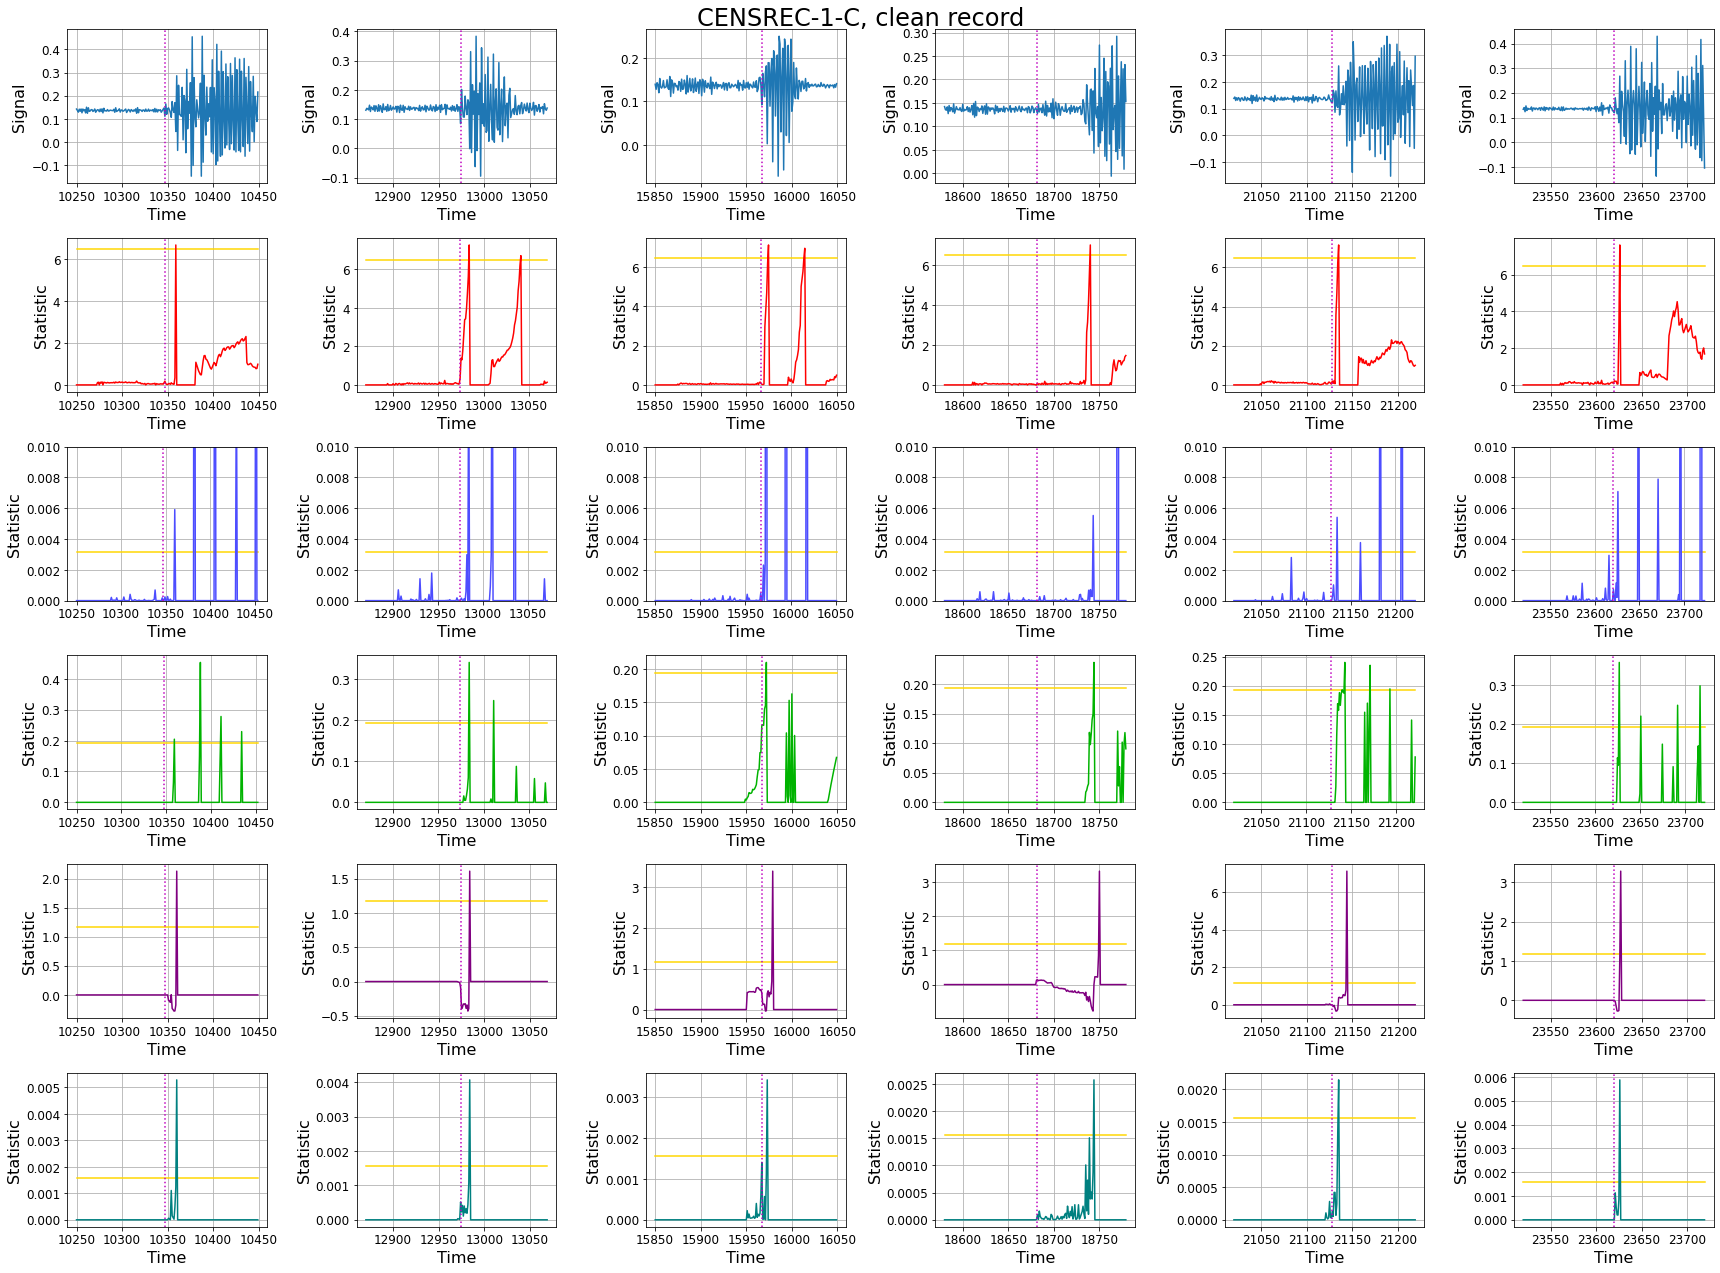

In [66]:
plt.figure(figsize=(24, 18))

l = len(data_test)

plt.suptitle(t='CENSREC-1-C, clean record', fontsize=24)
    
for i in range(l):
    
    plt.subplot(6, l, i + 1)
    plt.plot(np.arange(test_start[i], test_end[i]), data[test_start[i]:test_end[i]], c='tab:blue')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Signal', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_lin_all[i])), [z_lin] * len(S_lin_all[i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_lin_all[i])), S_lin_all[i], c='r',\
             label='contrastive + polynomials')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 2 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_nn_all[i])), [z_nn] * len(S_nn_all[i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_nn_all[i])), S_nn_all[i], c='#4d4dff',\
             label='contrastive + NN')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.ylim(0, 0.01)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 3 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_ftal_all[4 + i])), [z_ftal] * len(S_ftal_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_ftal_all[4 + i])), S_ftal_all[4 + i],\
             c='#00b300', label='Falcon')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 4 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_kliep_all[4 + i])), [z_kliep] * len(S_kliep_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_kliep_all[4 + i])), S_kliep_all[4 + i],\
             c='purple', label='KLIEP')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 5 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_mmd_all[4 + i])), [z_mmd] * len(S_mmd_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_mmd_all[4 + i])), S_mmd_all[4 + i],\
             c='teal', label='M-statistic')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
plt.tight_layout()
plt.savefig('images/CENSREC_clean_results.png')

### CENSREC, SNR = 20

In [67]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR20.wav')
audio = input_data[1]

# Data preprocessing

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


In [68]:
z_lin = 6.492324063835637
p = 3

S_lin_all = []

for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_lin = np.empty(0)

    # Initialization 
    st_lin = 0
    new_st_lin = 0

    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(ds[st_lin + 1:], p, design='poly',\
                                                         delta_max=50, threshold=z_lin)

        S_lin = np.append(S_lin, new_S_lin)

        if new_st_lin >= 0:
            st_lin += new_st_lin

    S_lin_all += [S_lin]

In [69]:
z_nn = 0.0031831283887076597

S_nn_all = []

for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_nn = np.empty(0)

    # Initialization 
    st_nn = 0
    new_st_nn = 0

    while new_st_nn >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_nn, new_st_nn = compute_test_stat_nn(ds[st_nn + 1:], n_epochs=20, delta_max=50, threshold=z_nn)

        S_nn = np.append(S_nn, new_S_nn)

        if new_st_nn >= 0:
            st_nn += new_st_nn

    S_nn_all += [S_nn]

In [70]:
z_ftal = 0.1934299703664984
b = 0.02
p = 3

S_ftal_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z_ftal)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            
    S_ftal_all += [S_ftal]
    
    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z_ftal)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            
    S_ftal_all += [S_ftal]

In [71]:
z_kliep = 1.1747125464198604
sigma = 0.075

S_kliep_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_kliep)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            
    S_kliep_all += [S_kliep]

    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_kliep)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            
    S_kliep_all += [S_kliep]

In [72]:
z_mmd = 0.0015690352677189098
sigma = 0.5

S_mmd_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_mmd)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            
    S_mmd_all += [S_mmd]
    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_mmd)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            
    S_mmd_all += [S_mmd]

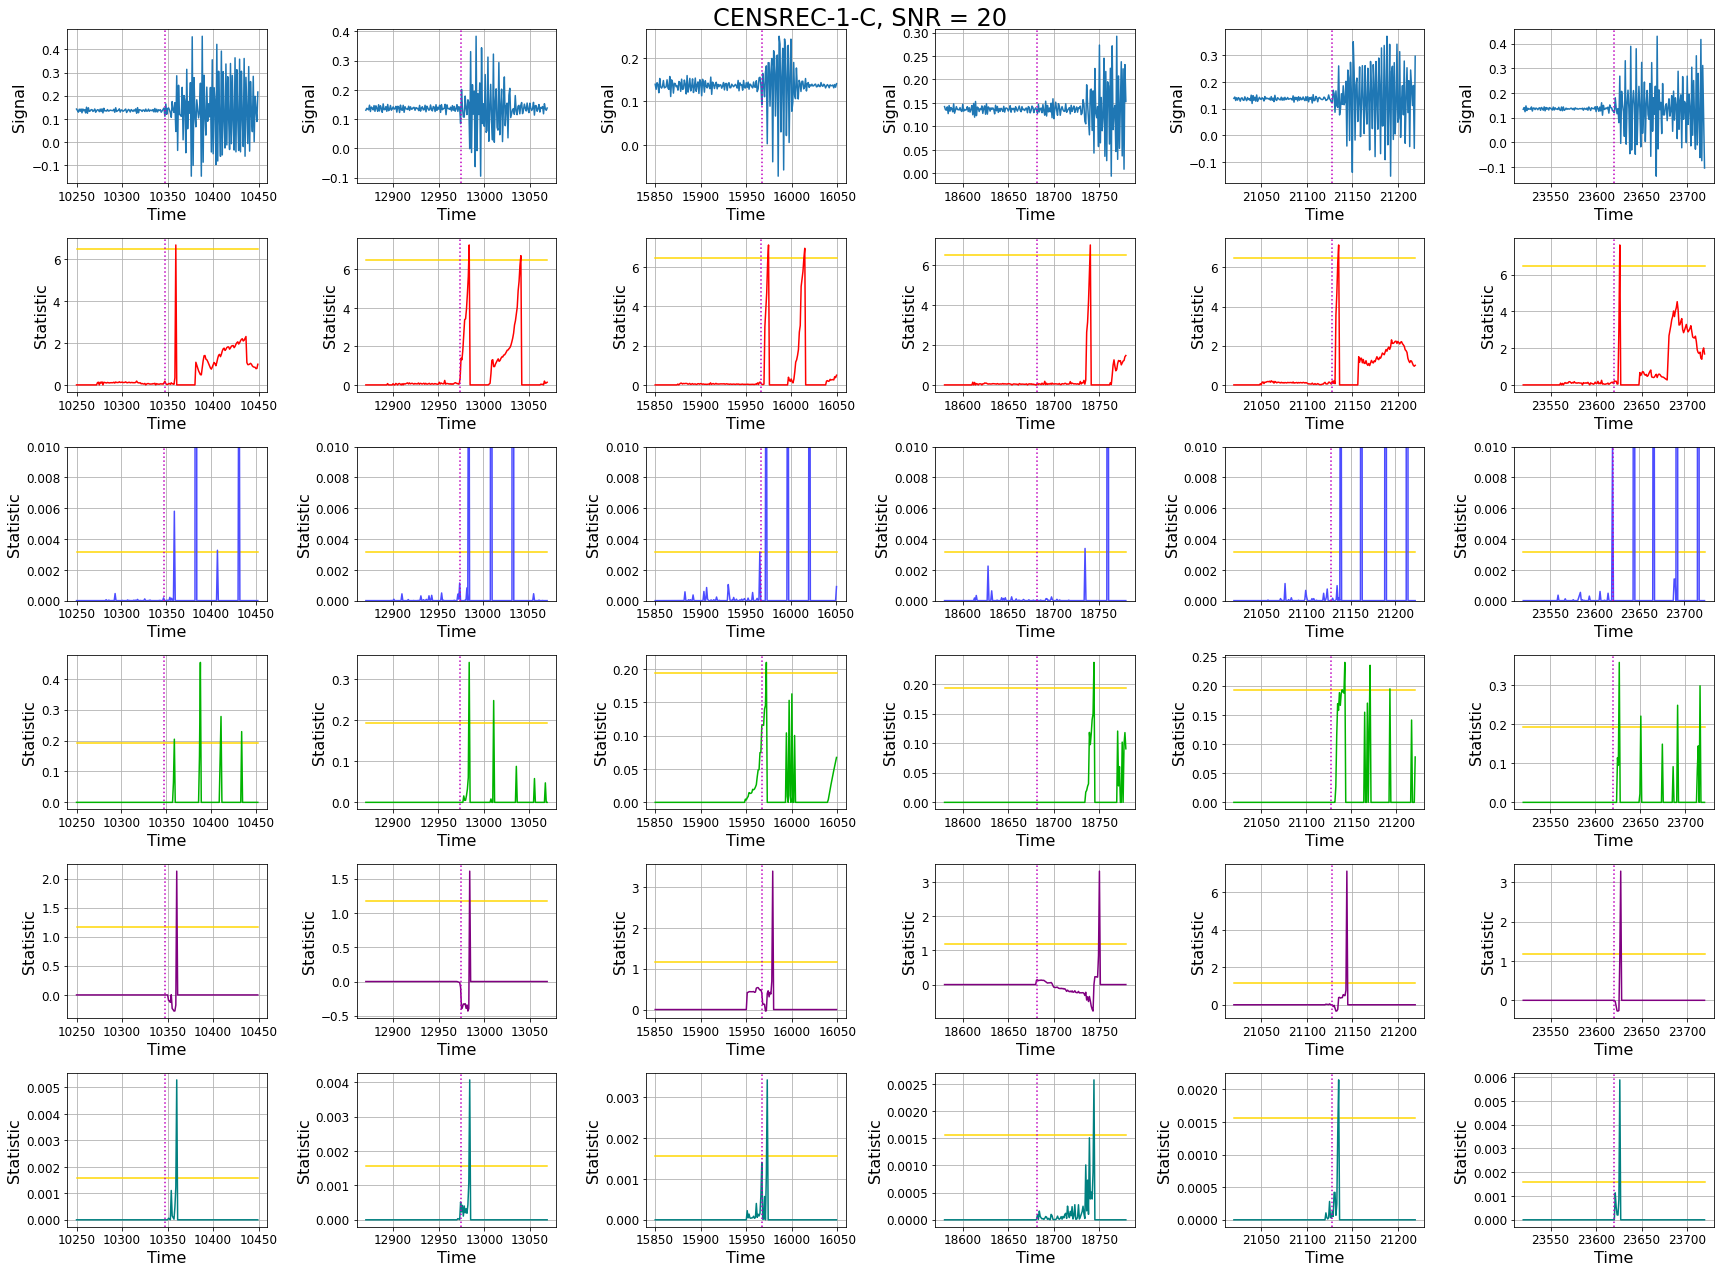

In [75]:
plt.figure(figsize=(24, 18))

l = len(data_test)

plt.suptitle(t='CENSREC-1-C, SNR = 20', fontsize=24)
    
for i in range(l):
    
    plt.subplot(6, l, i + 1)
    plt.plot(np.arange(test_start[i], test_end[i]), data[test_start[i]:test_end[i]], c='tab:blue')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Signal', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_lin_all[i])), [z_lin] * len(S_lin_all[i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_lin_all[i])), S_lin_all[i], c='r',\
             label='contrastive + polynomials')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 2 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_nn_all[i])), [z_nn] * len(S_nn_all[i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_nn_all[i])), S_nn_all[i], c='#4d4dff',\
             label='contrastive + NN')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.ylim(0, 0.01)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 3 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_ftal_all[4 + i])), [z_ftal] * len(S_ftal_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_ftal_all[4 + i])), S_ftal_all[4 + i],\
             c='#00b300', label='Falcon')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 4 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_kliep_all[4 + i])), [z_kliep] * len(S_kliep_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_kliep_all[4 + i])), S_kliep_all[4 + i],\
             c='purple', label='KLIEP')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 5 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_mmd_all[4 + i])), [z_mmd] * len(S_mmd_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_mmd_all[4 + i])), S_mmd_all[4 + i],\
             c='teal', label='M-statistic')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
plt.tight_layout()
plt.savefig('images/CENSREC_SNR20_results.png')

### CENSREC, SNR = 15

In [76]:
# Read the data
input_data = read('data/CENSREC/MAH_N1_SNR15.wav')
audio = input_data[1]

# Data preprocessing

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1))
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]

24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


In [77]:
z_lin = 3.801121860213868
p = 3

S_lin_all = []

for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_lin = np.empty(0)

    # Initialization 
    st_lin = 0
    new_st_lin = 0

    while new_st_lin >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_lin, new_st_lin = compute_test_stat_linear(ds[st_lin + 1:], p, design='poly',\
                                                         delta_max=50, threshold=z_lin)

        S_lin = np.append(S_lin, new_S_lin)

        if new_st_lin >= 0:
            st_lin += new_st_lin

    S_lin_all += [S_lin]

In [78]:
z_nn = 0.007237502957288469

S_nn_all = []

for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_nn = np.empty(0)

    # Initialization 
    st_nn = 0
    new_st_nn = 0

    while new_st_nn >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_nn, new_st_nn = compute_test_stat_nn(ds[st_nn + 1:], n_epochs=20, delta_max=50, threshold=z_nn)

        S_nn = np.append(S_nn, new_S_nn)

        if new_st_nn >= 0:
            st_nn += new_st_nn

    S_nn_all += [S_nn]

In [79]:
z_ftal = 0.1802302227839938
b = 0.01
p = 3

S_ftal_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z_ftal)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            
    S_ftal_all += [S_ftal]
    
    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization 
    st_ftal = 0
    new_st_ftal = 0

    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(ds[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z_ftal)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            
    S_ftal_all += [S_ftal]

In [80]:
z_kliep = 0.08597013432707712
sigma = 0.1

S_kliep_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_kliep)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            
    S_kliep_all += [S_kliep]

    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization 
    st_kliep = 0
    new_st_kliep = 0

    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(ds[st_kliep + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_kliep)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            
    S_kliep_all += [S_kliep]

In [81]:
z_mmd = 0.0001
sigma = 2

S_mmd_all = []

for i in range(len(data_val)):

    # Data
    ds = data_val[i]
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_mmd)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            
    S_mmd_all += [S_mmd]
    
for i in range(len(data_test)):

    # Data
    ds = data_test[i]
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization 
    st_mmd = 0
    new_st_mmd = 0

    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(ds[st_mmd + 1:],\
                                                          window_size=50, sigma=sigma, threshold=z_mmd)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            
    S_mmd_all += [S_mmd]

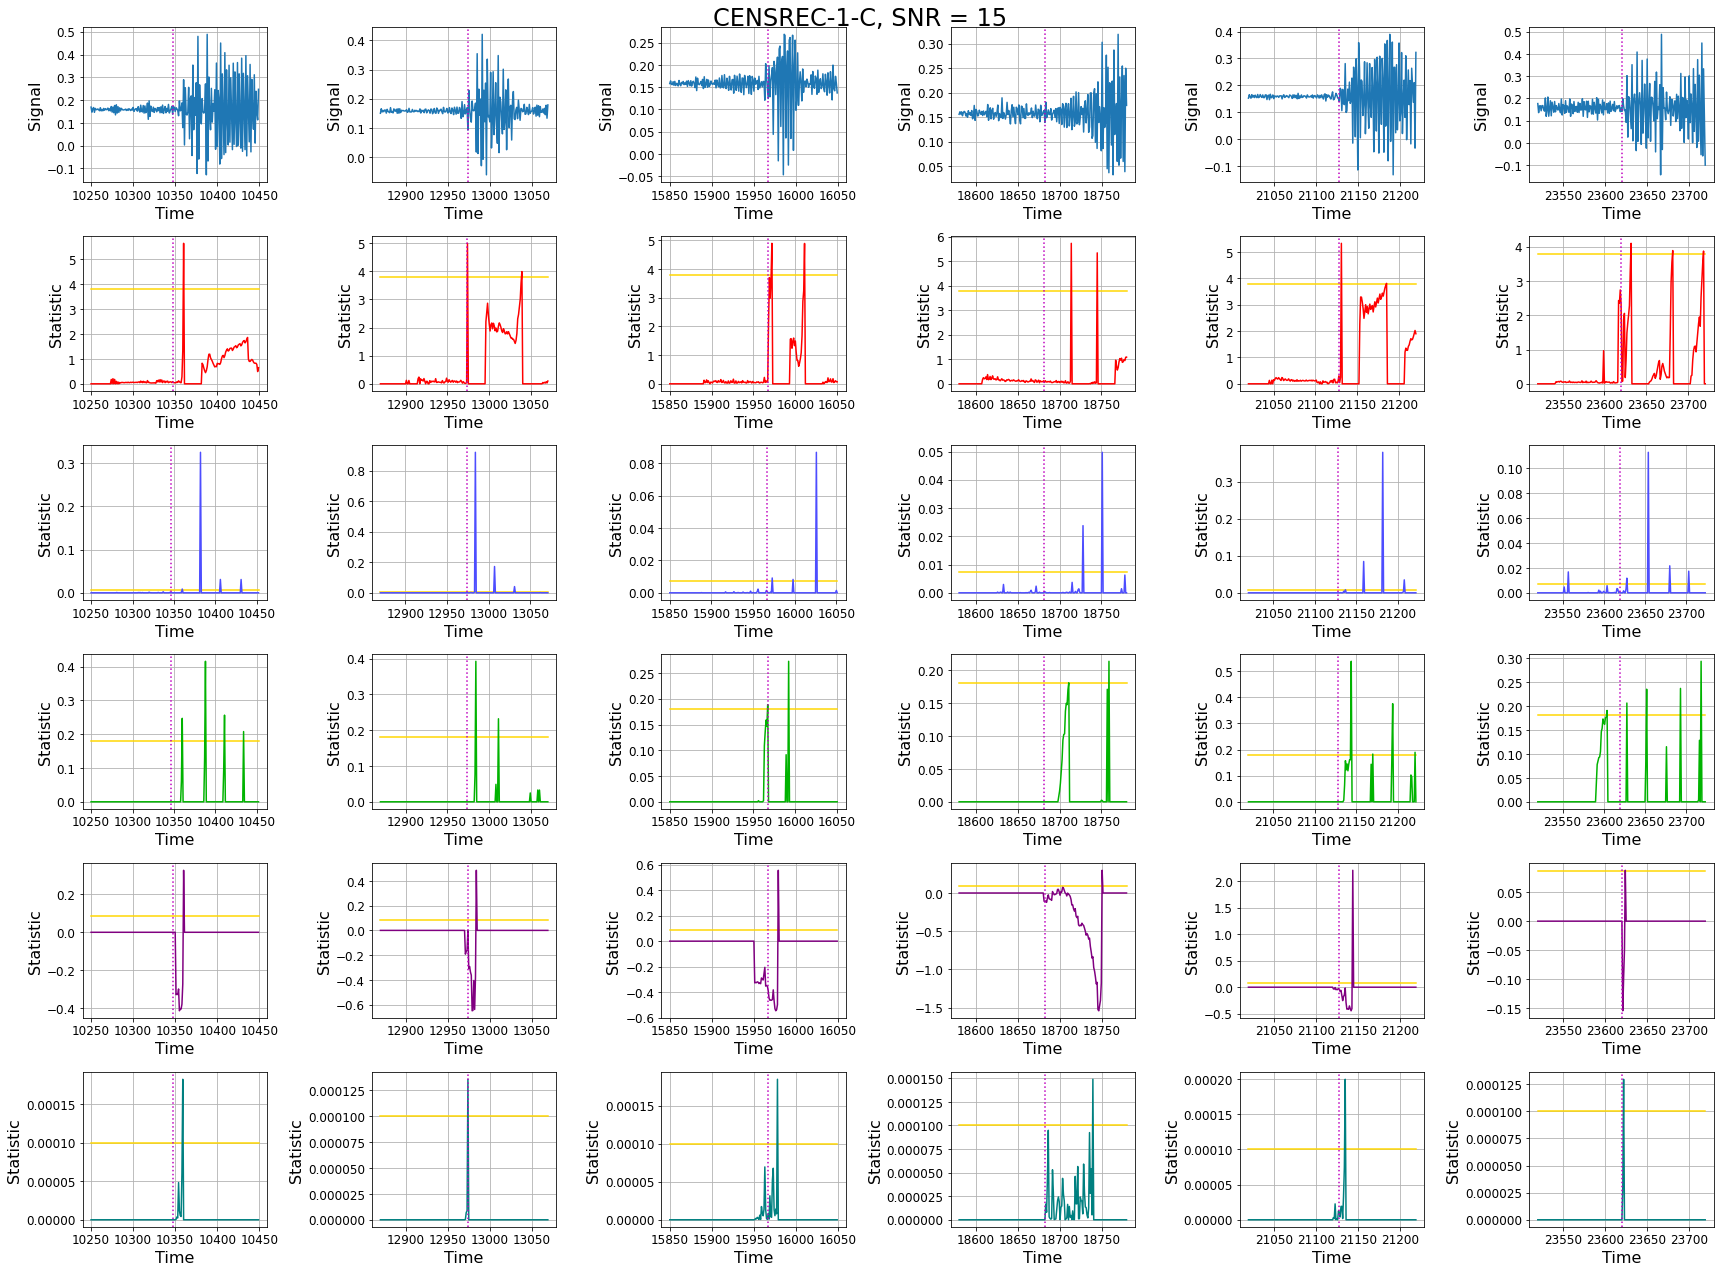

In [82]:
plt.figure(figsize=(24, 18))

l = len(data_test)

plt.suptitle(t='CENSREC-1-C, SNR = 15', fontsize=24)
    
for i in range(l):
    
    plt.subplot(6, l, i + 1)
    plt.plot(np.arange(test_start[i], test_end[i]), data[test_start[i]:test_end[i]], c='tab:blue')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Signal', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_lin_all[i])), [z_lin] * len(S_lin_all[i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_lin_all[i])), S_lin_all[i], c='r',\
             label='contrastive + polynomials')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 2 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_nn_all[i])), [z_nn] * len(S_nn_all[i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_nn_all[i])), S_nn_all[i], c='#4d4dff',\
             label='contrastive + NN')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 3 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_ftal_all[4 + i])), [z_ftal] * len(S_ftal_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_ftal_all[4 + i])), S_ftal_all[4 + i],\
             c='#00b300', label='Falcon')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 4 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_kliep_all[4 + i])), [z_kliep] * len(S_kliep_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_kliep_all[4 + i])), S_kliep_all[4 + i],\
             c='purple', label='KLIEP')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
    plt.subplot(6, l, 5 * l + i + 1)
    plt.plot(test_start[i] + np.arange(len(S_mmd_all[4 + i])), [z_mmd] * len(S_mmd_all[4 + i]), c='gold')
    plt.plot(test_start[i] + np.arange(len(S_mmd_all[4 + i])), S_mmd_all[4 + i],\
             c='teal', label='M-statistic')
    plt.axvline(change_points[4+i], c='m', ls=':')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Statistic', fontsize=16)
    plt.grid()
    
plt.tight_layout()
plt.savefig('images/CENSREC_SNR15_results.png')